# Electricity Demand Forecasting for Austin, TX

Final project for CMU 15-688 (Practical Data Science)
- Spandan Gandhi
- Harrison Van Til

![transmission towers image](http://www.tdworld.com/sites/tdworld.com/files/styles/article_featured_standard/public/towers-TebNad.jpg?itok=4cfkGQqZ)

## Contents

1. [Introduction](#intro)
2. [Data Collection](#collect)
    - [Electricity Demand Data](#demand)
    - [Weather Data](#weather)
3. [Feature Engineering](#features)
4. [Designing Models](#design)
    - [Monthly Averages Model: SARIMA](#monthly)
    - [Hourly Residuals Model: Regression](#hourly)
        - [Baseline](#baseline)
        - [Linear Regression](#linreg)
        - [Gradient Boosted Regression](#gbr)
        - [Multi-Layer Perceptron Regression](#mlp)
5. [Evaluating Final Models](#evaluate)
6. [Summary & Future Work](#summary)

<a id='intro'></a>
## 1. Introduction

Accurate forecasts for electricity demand are important for electric utilities and regional transmission organizations. Long term forecasts can reduce investment risk, medium term forecasts help in planning fuel purchases and scheduling plant maintenance, and short term forecasts are essential in matching electricity generation and demand for grid reliability.

This project focuses on medium term forecasting, specifically making one-week-out forecasts at a resolution of one hour for Austin, Texas. Historical electricity demand and weather data from 2002-2017 is used. A combination of timeseries analysis and regression models are used to make forecasting predictions, which are compared against the observed hourly electricity demand for a series of one-week intervals. 

<a id='collect'></a>
## 2. Data Collection

<a id='demand'></a>
### Electricity Demand Data

The Electric Reliability Council of Texas (ERCOT) provides historical electricity demand data, available [here](http://www.ercot.com/gridinfo/load/load_hist/). The demand data for each year is segmented by weather zones, as seen in the schematic below. This project chose to focus on the South Central weather zone, using corresponding weather data for the city of Austin. 

![ercot zones image](https://i.imgur.com/Ch9A0wh.png)

The following code defines helper functions for loading the raw data into a Pandas dataframe, taking into account different formatting among different years. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (7, 5)
plt.rcParams['figure.dpi'] = 125

# --- helper functions for loading/processing ERCOT data ---

def convert_ts_02to16(r):
    """converts timestamp string to datetime index for the years 2002 to 2016"""
    t=str(r.year)+'-'+str(r.month)+'-'+str(r.day)+' '
    if r.minute > 30:
        t += str(r.hour)
    else:
        t += str(r.hour - 1)
    t += ':0'
    return pd.to_datetime(t)

def convert_ts_17(r):
    """converts timestamp string to datetime index for the year 2017"""
    h = int(r[11:13])-1
    if h < 10:
        return pd.to_datetime(r[:11]+'0'+str(h)+r[13:])
    else:
        return pd.to_datetime(r[:11]+str(h)+r[13:])
    
def process_02to16(filename, load_col):
    """loads excel data into dataframe for the years 2002 to 2016"""
    df=pd.read_excel(filename, parse_cols='A,'+load_col, names=['time','load'])
    df['time'] = df['time'].apply(convert_ts_02to16)
    return df

def process_17(filename, load_col):
    """loads excel data into dataframe for the year 2017"""
    df=pd.read_excel(filename, parse_cols='A,'+load_col, names=['time','load'])
    df['time'] = df['time'].apply(convert_ts_17)
    return df

The raw data files are downloaded and stored in a local directory. The following code block calls the above helper functions to load the data into a single dataframe. Some basic processing is performed, such as converting timestamps to datetime indexes, removing duplicate entries (by taking an average of values with the same timestamp), and filling missing values (by backfilling from the next available entry). In total, there are over 140k data points at hourly resolution in the dataset.

,load
time,
2002-01-01 00:00:00,4793.193560
2002-01-01 01:00:00,4766.918187
2002-01-01 02:00:00,4702.918892
2002-01-01 03:00:00,4669.064391
2002-01-01 04:00:00,4695.011904


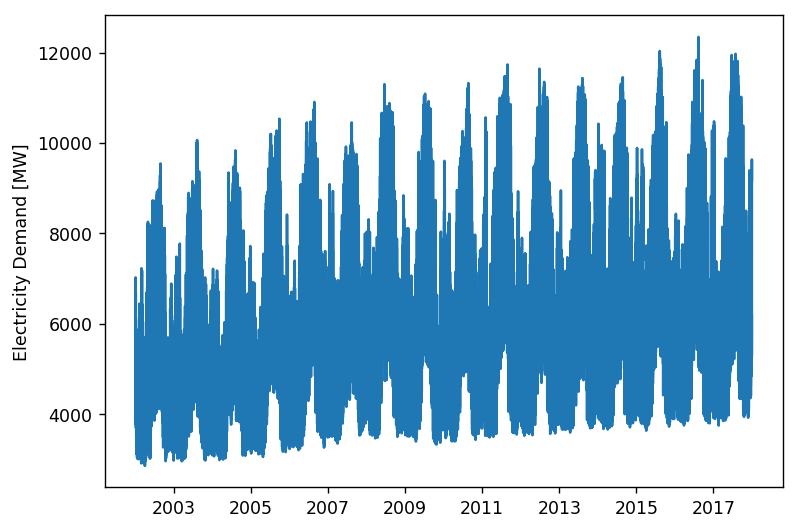

In [5]:
# setup list of filenames
path = 'ercot_data/'
suffix_02to14 = '_ERCOT_Hourly_Load_Data.xls'
fname_15 = 'native_Load_2015.xls'
filenames = []
for year in range(2002, 2015):
    filenames.append(path + str(year) + '_ERCOT_Hourly_Load_Data.xls')
filenames.append(path + 'native_Load_2015.xls')
for year in range(2016, 2018):
    filenames.append(path + 'native_Load_' + str(year) + '.xlsx')

# load each file into a dataframe
df_list = []
year = 2002
for filename in filenames:
    if year < 2017:
        df_list.append(process_02to16(filename, 'H'))
    else:
        df_list.append(process_17(filename, 'H'))
    year += 1
        
# combine into one dataframe and set datetime index
ercot_df = pd.concat(df_list)
ercot_df.set_index('time', inplace=True)

# fix missing/duplicate values
ercot_df = ercot_df.groupby('time').mean()
ercot_df = ercot_df.asfreq('H', method='pad')

# plot and show first 5 rows
plt.plot(ercot_df['load'])
plt.ylabel('Electricity Demand [MW]')
ercot_df.head()

<a id='weather'></a>
### Weather Data

Temperature, humidity, and other weather features are known to impact electricity consumption. This section covers the data collection process for acquiring weather data. 

Weather Underground provides an historical weather data API, which is found [here](https://www.wunderground.com/weather/api/). First, an API key must be obtained from Weather Underground. Next, a parser is built to extract relevant data from a single API endpoint. Finally, the data scraping script is extended to page through all dates of interest to compile hourly weather data from 2002-2017 into a single dataframe.

This first code block defines helper functions for converting timestamps to datetime indexes, taking care to round timestamps to the nearest hour (to align with the electricity demand data).

In [6]:
import io, time, json
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import re
from datetime import timedelta

def to_datetime(x):
    """converts timestamp string to datetime object"""
    return datetime.strptime(x, '%B %d %Y %I:%M %p')

def hour_rounder(t):
    """rounds to nearest hour by adding a timedelta hour if minute >= 30"""
    return t.replace(second=0,microsecond=0,minute=0,hour=t.hour) + timedelta(hours=t.minute//30)

This second code block is the heart of the data collection process. It scrapes a single webpage of weather data, returning two dataframes of weather data as well as the url for the next page.

In [8]:
def one_day(url):
    """web scraper to collect weather from single page"""
    day = requests.get(url)
    soup = BeautifulSoup(day.text, 'html.parser')
    a=soup.find_all('div', attrs={'class':'high-res'})

    date = soup.find_all('h2', attrs={'class':"history-date"})
    date = date[0]
    date = date.text
    
    try:
        a=a[0]
        rows=[]
        b = a.find_all('tr')
        for i in range(1,len(b)):
            c = b[i].find_all('td')
            rows.append(c)
            
        e = b[0].find_all('th')
        cols=[]
        for header in e:
            cols.append(header.text)

        weather = pd.DataFrame(columns = ['Time', 'Temp (F)', 'Humidity', 'Wind Speed', 'Condition'])
        data = []
        for k in rows:
            row={}
            time = k[0].text
            time = date+' '+time
            time = re.sub(r'.*day,', '', time)
            time = time.replace(',','')
            time = time[1:]
            try:
                temp = k[1].find('span', attrs={'class':'wx-value'}).text
            except:
                temp = None
                
            if len(cols)==13:    
                hum = k[4].text
                hum = hum[:-1]
                try:
                    wind_spd = k[8].find('span', attrs={'class':'wx-value'}).text
                except:
                    wind_spd = k[8].text
                cond = k[12].text
                
            if len(cols)==12:
                hum = k[3].text
                hum = hum[:-1]
                try:
                    wind_spd = k[7].find('span', attrs={'class':'wx-value'}).text
                except:
                    wind_spd = k[7].text
                cond = k[11].text
                
            row["Time"]=time
            row['Temp (F)']=temp
            row['Humidity']=hum
            row['Wind Speed']=wind_spd
            row["Condition"]=cond
            data.append(row)

        weather = weather.append(data,ignore_index=True)
        
        try:
            weather['Temp (F)'] = weather['Temp (F)'].astype('float64')
        except:
            pass
        
        try:
            weather['Humidity'] = weather['Humidity'].astype('float64')
        except:
            pass
        
        weather['Time'] = weather['Time'].apply(lambda x: hour_rounder((pd.to_datetime(to_datetime(x)))))
        weather = weather.replace(['N/A','\n -\n'], 50.0)
        weather1 = weather.copy()
        weather1['Humidity'] = weather1['Humidity'].astype('float64')
        weather1 = weather1.set_index('Time', drop=True)
        weather1 = weather1.resample('H').mean()
        weather1 = weather1.reset_index()

        n = soup.find_all('div', attrs={'class':'next-link'})
        n=n[0]
        nxt_date = 'https://www.wunderground.com'+n.find('a').get('href')
        return weather, weather1, nxt_date
    
    except:
        n = soup.find_all('div', attrs={'class':'next-link'})
        n=n[0]
        nxt_date = 'https://www.wunderground.com'+n.find('a').get('href')
        return None, None, nxt_date

The following code are a series of wrapper functions and helper functions which iteratively collect data from individual webpages for the entire span from 2002-2017, process this data into the a nice format, and save all data to a single CSV file for later use. Some notes on data processing:

- Most wind speed data is numeric, but some is missing or simply "calm". These are converted to the mean and lowest observed wind speed, respectively.
- Weather condition is a categorical feature. The string representation from the API is converted to an integer.
- Humidity values are converted to percentages on the range [0, 1].
- Hourly frequency of the data is enformced (i.e. duplicate entries are removed).

In [9]:
def all_days(url, no_of_days):
    """crawls through a given number of days to collect weather data"""
    list1 = []
    list2 = []
    result = one_day(url)
    list1.append(result[0])
    list2.append(result[1])
    
    for i in range(no_of_days -1):
        if result != None:
            result = one_day(result[2])
            list1.append(result[0])
            list2.append(result[1])
            
    weather1 = pd.concat(list1).reset_index(drop=True)
    weather2 = pd.concat(list2).reset_index(drop=True)
    return weather1, weather2

def t_or_e(x):
    """process irregular wind speed data"""
    try:
        return float(x)
    except:
        if x=='Calm':
            return 3.0
        else:
            return 4.5
        
def process(df):
    """general purpose weather data processing"""
    y = df.Condition.unique().tolist()
    y = sorted(y)
    df['Condition'] = df['Condition'].apply(lambda x: y.index(x))
    df['Wind Speed'] = df['Wind Speed'].apply(lambda x: t_or_e(x))
    df['Time'] = df['Time'].apply(lambda x: pd.to_datetime(x))
    df['Humidity'] = df['Humidity'].astype('float64')
    df['Humidity'] = df['Humidity'].apply(lambda x: x/100)
    df = df.set_index('Time', drop=True).resample('H').mean().reset_index()
    return df

def one_year(year):
    """processes an entire year of weather data"""
    all_months = list(range(1,13))
    days_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]
    if year%4 == 0:
        days_in_month[1] = 29
    Month = list(zip(all_months,days_in_month))
    
    all_months_1 = []
    all_months_2 = []
    for i in Month:
        url_initial = ('https://www.wunderground.com/history/airport/KATT/' + 
                       str(year) + '/' + str(i[0]) + 
                       '/1/DailyHistory.html?req_city=&req_state=&req_statename=&reqdb' + 
                       '.zip=&reqdb.magic=&reqdb.wmo=')
        res = all_days(url_initial,i[1])
        all_months_1.append(res[0])
        all_months_2.append(res[1])

    all_Months_1 = pd.concat(all_months_1).reset_index(drop=True)
    all_Months_2 = pd.concat(all_months_1).reset_index(drop=True)
    all_Months_1 = process(all_Months_1)
    return all_Months_1, all_Months_2

def all_years(list_of_years):
    """for a given set of years, collect all weather data"""
    Weather_data = []
    for k in list_of_years:
        Weather_data.append(one_year(k)[0])
    Weather_data_all = pd.concat(Weather_data).reset_index(drop=True)
    Weather_data_all.to_csv('Weather_data_all.csv')
    
all_years(list(range(2002,2018)))

To illustrate the final result of weather data scraping, and as set up for the next section, the weather CSV is loaded into a dataframe and a sample of 5 rows is shown.

In [15]:
filename = 'Weather_data_all.csv'
weather_df = pd.read_csv(filename).drop('Unnamed: 0', axis=1)
weather_df.columns = ['time', 'temp', 'humd', 'wnsp', 'cond']
weather_df['time'] = weather_df['time'].apply(lambda x: pd.to_datetime(x))
weather_df.head()

,time,temp,humd,wnsp,cond
0,2002-01-01 01:00:00,36.0,0.64,6.9,0.0
1,2002-01-01 02:00:00,36.0,0.57,8.1,0.0
2,2002-01-01 03:00:00,36.0,0.57,8.1,0.0
3,2002-01-01 04:00:00,36.0,0.57,5.8,0.0
4,2002-01-01 05:00:00,35.1,0.61,8.1,8.0


<a id='features'></a>
## 3. Feature Engineering

First, the categorical feature "condtion" is converted into a one-hot encoding. The original dataset from Weather Underground uses a convention of 17 different weather condtions, many of which are quite similar. The 17 original categories are grouped into 6 broad categories, as described below:

|Weather Group|Original Conditions|
|-|-|
|clear|clear|
|cloud|scattered clouds, partly cloudy, mostly cloudy, overcast|
|rain|rain, light rain, heavy rain|
|tstorm|thunderstorm, thunderstorms and rain, light thunderstorm and rain, heavy thunderstorm and rain|
|fog|fog, haze, mist|
|snow|light snow|

In [16]:
# helper functions for defining one hot encoding
def tstorm(x):
    if x==14 or x==15 or x==7 or x==4:
        return 1
    return 0

def clear(x):
    if x==0:
        return 1
    return 0

def fog(x):
    if x==1 or x==2 or x==8:
        return 1
    return 0

def rain(x):
    if x==3 or x==5 or x==12:
        return 1
    return 0

def cloud(x):
    if x==9 or x==10 or x==11 or x==13:
        return 1
    return 0

def snow(x):
    if x==6:
        return 1
    return 0

# create one hot encoding
weather_df['tstorm'] = weather_df['cond'].apply(tstorm)
weather_df['clear'] = weather_df['cond'].apply(clear)
weather_df['fog'] = weather_df['cond'].apply(fog)
weather_df['rain'] = weather_df['cond'].apply(rain)
weather_df['cloud'] = weather_df['cond'].apply(cloud)
weather_df['snow'] = weather_df['cond'].apply(snow)

# drop original column
weather_df.drop('cond', axis=1, inplace=True)

Next, the electricity demand and weather data are merged into a single dataframe. Missing values created by the merge need to be filled in: for the one-hot encoding features back-filling is used, for the continuous features interpolation is used.

In [17]:
# merge and set index
df = ercot_df.merge(weather_df, how='left', left_index=True, right_on='time')
df.set_index('time', inplace=True)

# fix missing values
df['tstorm'] = df['tstorm'].bfill()
df['clear'] = df['clear'].bfill()
df['fog'] = df['fog'].bfill()
df['rain'] = df['rain'].bfill()
df['cloud'] = df['cloud'].bfill()
df['snow'] = df['snow'].bfill()
df.interpolate(inplace=True)
df.bfill(inplace=True)

Next, temporal features are created. For instance, whether it is a weekday or not likely has an impact on electricity consumption, so a boolean feature "weekday" is created. Similarly, the time of day certainly has a large impact on electricity consumption. Even though this is a time series problem, in the next section the model in this project is decomposed into two parts. To capture time of day effects in the second part an explicit feature must be created. Since time is a cyclic variable, a sine/cosine transformation is used on the hour the day. 

In [18]:
df['weekday'] = (df.index.weekday < 5).astype(int)
df['sin_hour'] = np.sin(2*np.pi*df.index.hour.values/24)
df['cos_hour'] = np.cos(2*np.pi*df.index.hour.values/24)

Finally, continuous features must be normalized, as models are generally easier to train if all features are on roughly the same scale. The simplest method for normalizing is to simply transform each continous feature to be on the range [0, 1]. Note that the minimum and maximum values for each feature are saved in order to transform them back to their original scale later.

In [20]:
df_norm = df.copy()

load_min, load_max = df['load'].min(), df['load'].max()
temp_min, temp_max = df['temp'].min(), df['temp'].max()
wnsp_min, wnsp_max = df['wnsp'].min(), df['wnsp'].max()

df_norm['load'] = (df['load'] - load_min) / (load_max - load_min)
df_norm['temp'] = (df['temp'] - temp_min) / (temp_max - temp_min)
df_norm['wnsp'] = (df['wnsp'] - wnsp_min) / (wnsp_max - wnsp_min)

df_norm.head()

,load,temp,humd,wnsp,tstorm,clear,fog,rain,cloud,snow,weekday,sin_hour,cos_hour
time,,,,,,,,,,,,,
2002-01-01 00:00:00,0.203966,0.318182,0.64,0.165957,0.0,1.0,0.0,0.0,0.0,0.0,1,0.000000,1.000000
2002-01-01 01:00:00,0.201196,0.318182,0.64,0.165957,0.0,1.0,0.0,0.0,0.0,0.0,1,0.258819,0.965926
2002-01-01 02:00:00,0.194450,0.318182,0.57,0.217021,0.0,1.0,0.0,0.0,0.0,0.0,1,0.500000,0.866025
2002-01-01 03:00:00,0.190881,0.318182,0.57,0.217021,0.0,1.0,0.0,0.0,0.0,0.0,1,0.707107,0.707107
2002-01-01 04:00:00,0.193616,0.318182,0.57,0.119149,0.0,1.0,0.0,0.0,0.0,0.0,1,0.866025,0.500000


<a id='design'></a>
## 4. Designing Models

In general, time series forecasting becomes quite difficult as the period of forecasting decreases. Therefore, this project decomposes the original electricity demand timeseries into two components. The first component is the monthly average electricity demand, which is modeled using traditional timeseries methods. The second component is what this project will refer to as the "hourly residuals". In other words, after removing the monthly averages from the orignal timeseries, what is left over is the amount above or below the monthly average at each hour (hence, hourly residual). The hourly residuals are modeled using various regression models, and are what the engineered features are used to help predict. After building two models (monthly and hourly), the predictions from each can be added together to get a full prediction for the electrcity demand at hourly frequency.

<a id='monthly'></a>
### Monthly Averages Model: SARIMA

Traditional timeseries methods are used to model the monthly average electricity demand. Since there is strong yearly seasonality in the data, a seasonal ARIMA (SARIMA) model is trained. Below, the monthly averages are extracted from the hourly data using resampling.

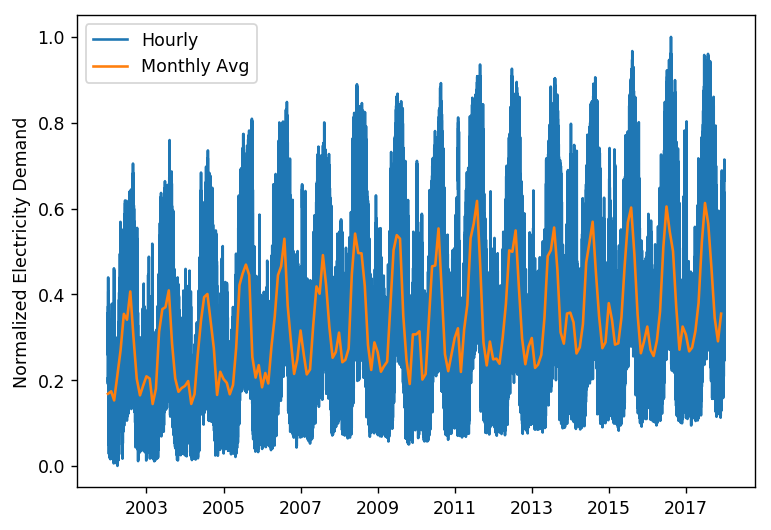

In [21]:
monthly_norm = df_norm['load'].resample('MS').mean().bfill()
plt.plot(df_norm['load'], label='Hourly')
plt.plot(monthly_norm, label='Monthly Avg')
plt.ylabel('Normalized Electricity Demand')
plt.legend();

Detailed information about SARIMA models may be found [here](https://people.duke.edu/~rnau/seasarim.htm). From the above plot and intuition, it's clear that this timeseries has yearly seasonality, i.e. $ m = 12 $. For the remaining hyper-parameters, the timeseries data is split into a training, validation, and test set, and they are tuned by performing a grid search and optimizing based upon validation set performance. Note that these sets are chosen sequentially, not randomly, because timeseries data must remain in its original sequence in order to be meaningful.

In [22]:
train = monthly_norm[:'2014']
validate = monthly_norm['2015':'2016']
test = monthly_norm['2017':]

For forecasting electricity demand, the conventional error metric is mean absolute percentage error (MAPE), which is also used in this project. 

$$ MAPE = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{\hat{y_i}-y_i}{y_i} \right| $$

However, since normalized features are used, the denominator in the MAPE error equation is always less than 1 and this value can grow quite large. To prevent numerical issues, standard MAE is used for grid search while MAPE is used for test set evaluation on the original scale data.

$$ MAE = \frac{1}{n} \sum_{i=1}^{n} \left| \hat{y_i}-y_i \right| $$

The [statsmodels](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) library is used to build a SARIMA model. Based on rules of thumb and the properties of this dataset, only values of 0 or 1 are considered for each hyperparameter.

In [24]:
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

# train SARIMA model and get validation set performance
def get_sarima_mae(y_tr, hp, y_te):
    try:
        model = SARIMAX(y_tr, order=(hp[0],hp[1],hp[2]), seasonal_order=(hp[3],hp[4],hp[5],12)).fit()
        y_hat = model.get_forecast(steps=len(y_te)).predicted_mean
        return np.mean(np.abs(y_hat - y_te))
    except:
        return None

# define potential SARIMA hyerparameters
p = d = q = P = D = Q = range(2)
hp_list = list(product(p,d,q,P,D,Q))
grid_search = pd.DataFrame(columns=['p','d','q','P','D','Q','mae'])

# perform grid search
for i, hp in enumerate(hp_list):
    mae = get_sarima_mae(train, hp, validate)
    if mae != None:
        params = {'p':hp[0], 'd':hp[1], 'q':hp[2], 'P':hp[3], 'D':hp[4], 'Q':hp[5], 'mae':mae}
        grid_search = grid_search.append(params, ignore_index=True)

# display best performing hyperparamters
grid_search.sort_values('mae').head(1)

,p,d,q,P,D,Q,mae
44,1.0,1.0,1.0,0.0,1.0,0.0,0.02265


The final monthly averages model is trained using the best hyperparameters found in grid search. Its forecasted predictions for the validation set are plotted against the observed values. This model appears to perform quite well.

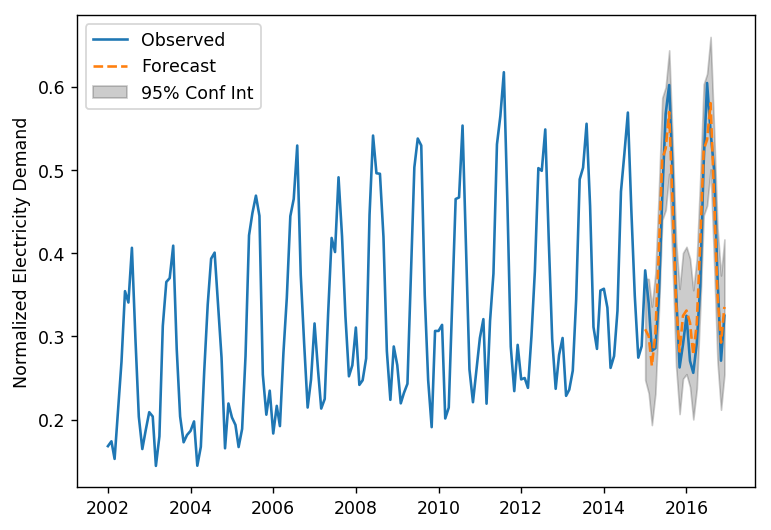

In [26]:
# best hyperparameters from grid search
best_monthly_order = (1,1,1)
best_monthly_seas_order = (0,1,1,12)

# fit SARIMA model
model_m = SARIMAX(train, order=best_monthly_order, seasonal_order=best_monthly_seas_order).fit()

# get forecast and confidence interval for forecast
forecast = model_m.get_forecast(steps=len(validate))
pred = pd.Series(forecast.predicted_mean, index=validate.index)
ci = forecast.conf_int(alpha=0.05)

# plotting
plt.plot(monthly_norm[:'2016'], label='Observed')
plt.plot(pred, label='Forecast', ls='--')
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1],
                 color='k', alpha=0.2, label='95% Conf Int')
plt.ylabel('Normalized Electricity Demand')
plt.legend();

After fitting a final monthly averages model, a few insights can be drawn about the dataset. First, a clear upward trend is seen in the electricity demand. This is not surprising, as the population of Austin and the surrounding Central Texas region has grown significantly during this time period [[source](https://www.bizjournals.com/austin/news/2018/03/22/austins-population-keeps-popping-heres-how-many.html)]. Second, a clear yearly seasonality is seen which peaks in summer and bottoms out in winter, while also showing a smaller local peak each winter. The peak electricity consumption in summer is expected (air-conditioning in hot Texas summers), but the small peak each winter is interesting. A closer inspection of the data shows this occurs annualy around the Christmas and New Years holidays. This either suggests holiday celebrations are consuming more electricity than normal, or that this also corresponds with the coldest time of year and extra electricity is being consumed for heating purposes. 

<a id='hourly'></a>
### Hourly Residuals Model: Regression

As mentioned previously, the hourly residuals are extracted from the original timeseries data by simply subtracting the monthly average. Below is a plot of the these hourly residuals, which will now be easier model with the trend and seasonality removed.

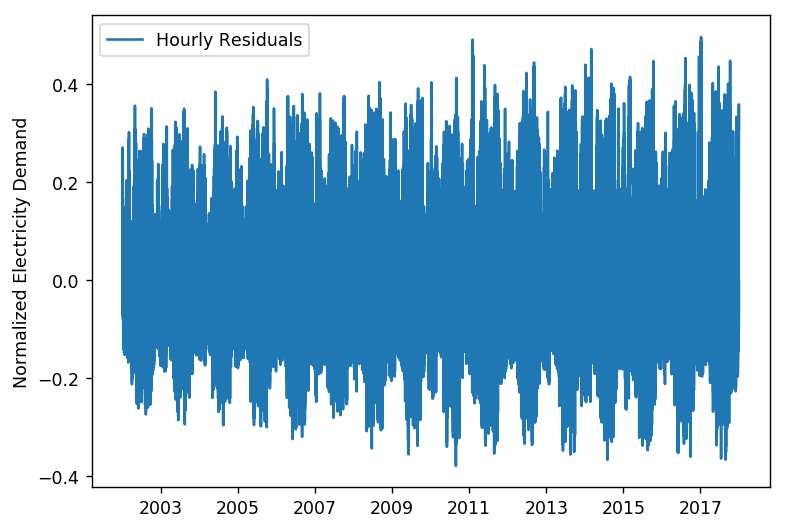

In [27]:
hourly_res_norm = df_norm.copy()
hourly_res_norm['load'] = df_norm['load'].groupby(pd.Grouper(freq='M')).transform(lambda x: x - x.mean())
plt.plot(hourly_res_norm['load'], label='Hourly Residuals')
plt.ylabel('Normalized Electricity Demand')
plt.legend();

Three regression models are studied in order to find the most accurate forecasting model. Note that since this is still time series data, an ARIMA model could still be used. However, it was found to give poor forecasting predictions, and was much slower to train and had comprable results than linear regression. The three regression models studied in this project are linear regression, gradient boosting regression (GBR), and multi-layer perceptron (MLP) regression. The [scikit-learn](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning) implementation of each of these models is used in this project. The following code block performs some setup for training these models.

In [29]:
# train-validate-test split
train = hourly_res_norm[:'2014']
validate = hourly_res_norm['2015':'2016']
test = hourly_res_norm['2017':]

# setup training variables 
exog_tr = train.iloc[:,1:].values
ar_tr = train['load'].shift().bfill().values[:,None]
X_tr = np.hstack([ar_tr, exog_tr])
y_tr = train['load'].values

# setup validation variables
exog_val = validate.iloc[:,1:].values
y_val = validate['load'].values

# setup testing variables
exog_te = test.iloc[:,1:].values

# setup miscellaneous variables
yp_full = hourly_res_norm.loc[:'2016','load']
yp_val = hourly_res_norm.loc['2015':'2016','load']
yp_te = hourly_res_norm.loc['2017':,'load']
y_init_val = np.hstack([y_tr[-1], validate.iloc[167::168,0].values])
y_init_te = np.hstack([y_val[-1], test.iloc[167::168,0].values])

Several helper functions are defined for building, evaluating, and tuning the regression models. Like above, MAE is used during grid search to tune hyperparameters. Since the goal of this project is to make accurate one-week-out forecasts at hourly frequency, the metric for evaluating performance is to make a series of one-week-out forecasts for the entire validation/test set, and simply concatenate this weekly forecasts together. The reason for making is a series of weekly forecasts rather than a year long forecast is that forecasting errors snowball, and this would be an unreasonable standard to hold these predictions to. Helper functions for making a one-week-out forecast and also for stringing together a series of these forecasts are defined below, as well as some plotting functions.

In [30]:
def compute_mae(y, yhat):
    """given predicted and observed values, computes mean absolute error"""
    return np.mean(np.abs(yhat - y))

def forecast(model, exog, y_init):
    """given a trained model, exogenous features, and initial AR term, makes forecasting predictions"""
    yhat = []
    Xi_te = np.hstack([y_init, exog[0]])[None,:]
    for i in range(len(exog)-1):
        yhat_i = model.predict(Xi_te)[0]
        yhat.append(yhat_i)
        Xi_te = np.hstack([yhat_i, exog[i+1]])[None,:]
    yhat.append(model.predict(Xi_te)[0])
    return np.array(yhat)

def weekly_forecast(model, exog, y_init):
    """given a trained model exogenous features, and initial AR term, makes a series of 1-week-out forecasts"""
    yhat = []
    for i, yi in enumerate(y_init):
        exog_i = exog[168*i:168*(i+1),:]
        if exog_i.shape[0] < 1:
            break
        yhat.append(forecast(model, exog_i, yi))
    return np.hstack(yhat)

def plot_full(y, yhat, yhat_idx):
    """plots observed and forecasted values for the full date range"""
    pred = pd.Series(yhat, index=yhat_idx)
    plt.figure()
    plt.plot(y, label='Observed')
    plt.plot(pred, label='Forecast', ls='--')
    plt.ylabel('Normalized Hourly Residual Electricity Demand')
    plt.legend()
    
def plot_week(y, yhat, yhat_idx):
    """plots observed and forecasted values for one week span"""
    pred = pd.Series(yhat, index=yhat_idx)
    fig = plt.figure();
    plt.plot(y['2016-12-01':'2016-12-07'], label='Observed')
    plt.plot(pred['2016-12-01':'2016-12-07'], label='Forecast', ls='--')
    plt.ylabel('Normalized Hourly Residual Electricity Demand')
    plt.legend()
    fig.autofmt_xdate()

<a id='baseline'></a>
#### Baseline

All models need a baseline against which to compare, and for timeseries models the conventional baseline is the persistance model. Essentially, the last observed value is used as the next predicted value. In the case of this project making one-week-out forecasts, the last observed value of the previous week is used as the predicted value for all hourly residuals for following week.

MAE: 0.119884364075


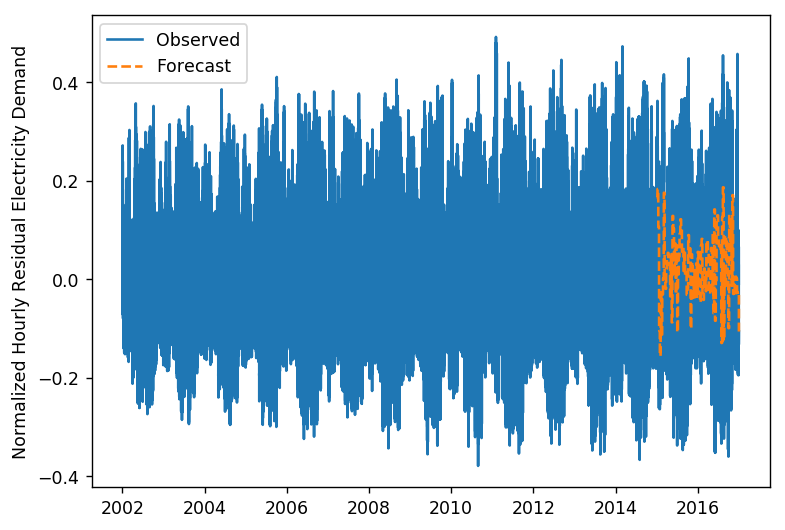

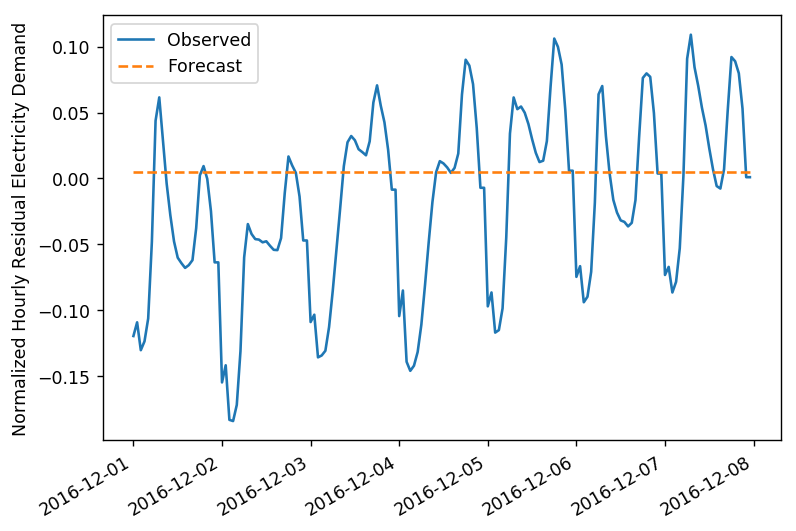

In [31]:
# get forecast "predictions" from the baseline persistance model
idx = validate.index[::168]
idx = idx.append(pd.DatetimeIndex(['2016-12-31 23']))
pred = pd.Series(np.hstack([y_init_val, yp_val.iloc[-1]]), index=idx)
pred = pred.resample('H').ffill().values

# compute error, and plot on both long and short time scales
print('MAE:', compute_mae(y_val, pred))
plot_full(yp_full, pred, yp_val.index)
plot_week(yp_full, pred, yp_val.index)

<a id='linreg'></a>
#### Linear Regression

Perhaps the simplest regression model is linear regression, so this was the first attempted model for the hourly residuals. Simple linear regression (i.e. without regularization) has no hyperparameters. Below are the results of training the linear regression model.

MAE: 0.0807701371137


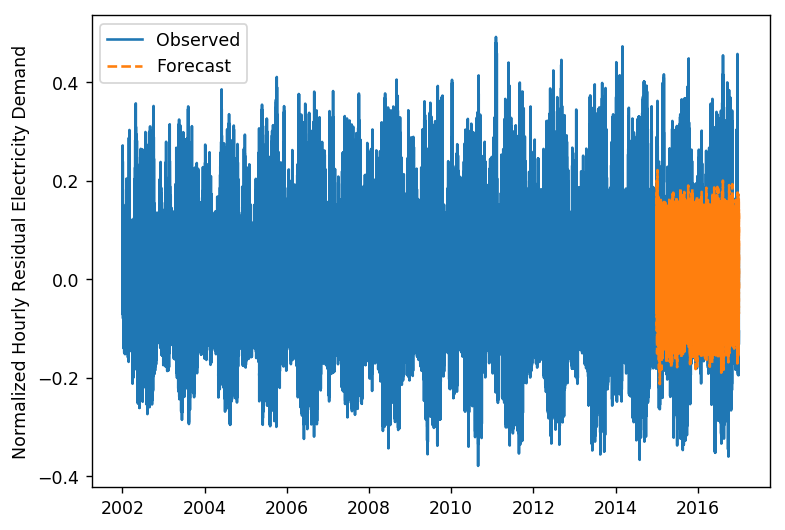

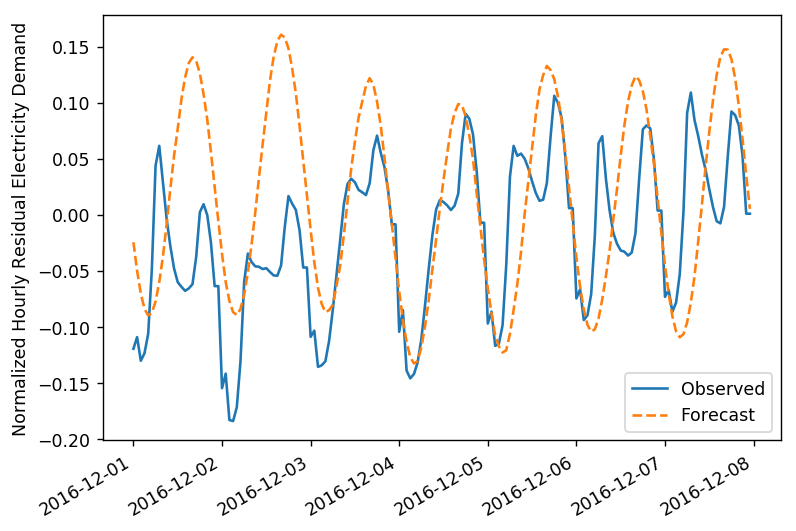

In [32]:
from sklearn.linear_model import LinearRegression

# train model and get predictions
mod_lr = LinearRegression()
mod_lr.fit(X_tr, y_tr)
pred = weekly_forecast(mod_lr, exog_val, y_init_val)

# compute error, and plot on both long and short time scales
print('MAE:', compute_mae(y_val, pred))
plot_full(yp_full, pred, yp_val.index)
plot_week(yp_full, pred, yp_val.index)

Linear regression performs better than the baseline, but qualitatively does not appear to fit the data very well. In particular, the forecasts don't appear to be much more than a slightly meandering sine wave. What is likely occuring is that the sine/cosine transform of hour of the day is being given significantly more weight than the other features, and in fact of one checks the coefficients of the fitted model this is the case.

<a id='gbr'></a>
#### Gradient Boosted Regression

The GBR model has a few important hyperparameters which must be tuned: learning rate, number of estimators, and maximum depth being the most important. For each of these hyperparameters, three values are chosen based on intuition and which are near the default parameters.

In [45]:
from sklearn.ensemble import GradientBoostingRegressor

# train GBR model, and get validation set performance
def get_gbr_mae(lr, ne, md):
    mod = GradientBoostingRegressor(learning_rate=lr, n_estimators=ne, max_depth=md)
    mod.fit(X_tr, y_tr)
    pred_val = weekly_forecast(mod, exog_val, y_init_val)
    return compute_mae(y_val, pred_val)

# define potential sets of hyperparameters
learning_rate = [0.01, 0.1, 1.]
n_estimators = [100, 500, 1000]
max_depth = [2, 3, 4]
grid_search = pd.DataFrame(columns=['lr','ne','md','mae'])

# perform grid search
for lr in learning_rate:    
    for ne in n_estimators:        
        for md in max_depth:            
            mae = get_gbr_mae(lr, ne, md)
            params = {'lr':lr, 'ne':ne, 'md':md, 'mae':mae} 
            grid_search = grid_search.append(params, ignore_index=True)

# display best hyperparameters based on grid search
grid_search.sort_values('mae').head(1)

,lr,ne,md,mae
14,0.1,500,4,0.044954


The best hyperparametres are recorded, and the final gradient boosting model is trained. Its forecasting performance is visualized, and the MAE is computed.

MAE: 0.0449469987432


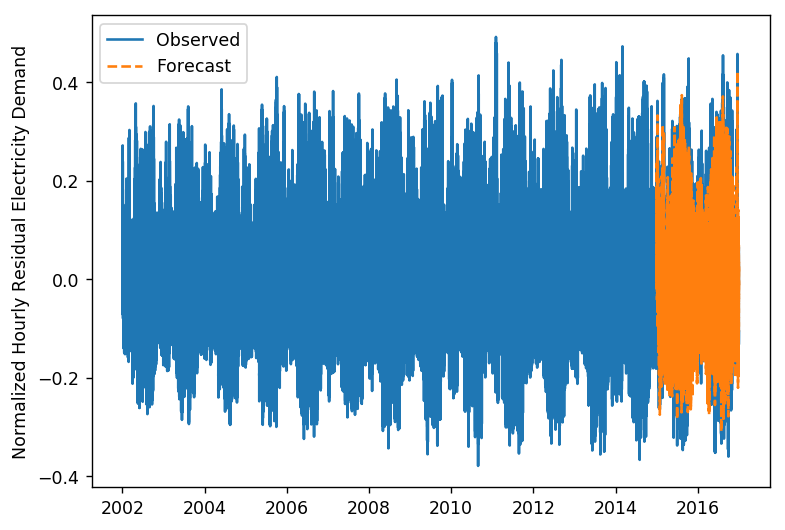

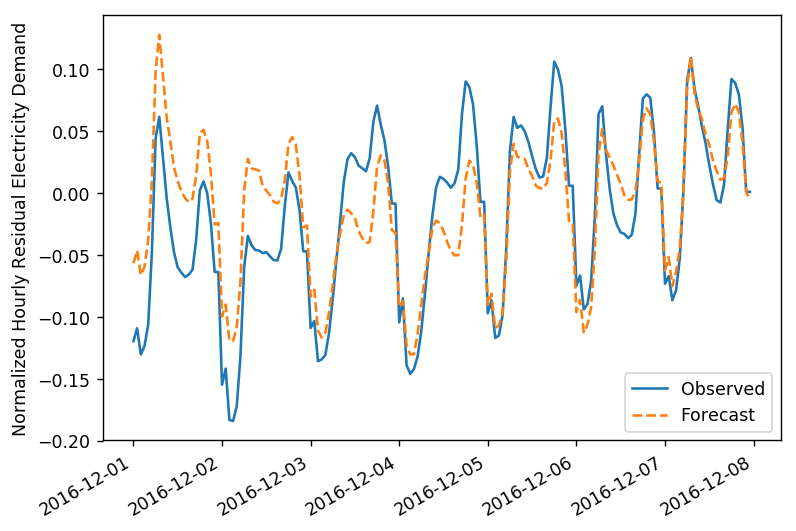

In [46]:
# best hyperparamters
lr, ne, md = 0.1, 500, 4

# train model and get predictions
mod_gbr = GradientBoostingRegressor(learning_rate=lr, n_estimators=ne, max_depth=md)
mod_gbr.fit(X_tr, y_tr)
pred = weekly_forecast(mod_gbr, exog_val, y_init_val)

# compute error, and plot on both long and short time scales
print('MAE:', compute_mae(y_val, pred))
plot_full(yp_full, pred, yp_val.index)
plot_week(yp_full, pred, yp_val.index)

The GBR model performs much better than linear regression. In particular, it captures the daily peaks and valleys very well, at least in shape.

<a id='mlp'></a>
#### Multi-Layer Perceptron Regression

This projects studies the use of the most general type of neural network, a multi-layer perceptron (MLP) model. In this, the number of hidden layers, number of neurons per layer, regularization, learning rate, and maximum number of training iterations per epoch must be specified. Clearly, there are significantly more hyperparameters compared to GBR. A small sample is chosen to perform a grid search over for this project.

In [67]:
from sklearn.neural_network import MLPRegressor

# train MLP model, and get validation set performance
def get_mlp_mae(hl, a, lr, mi):
    mod = MLPRegressor(hidden_layer_sizes=hl, alpha=a, learning_rate_init=lr, max_iter=mi)
    mod.fit(X_tr, y_tr)
    pred_val = weekly_forecast(mod, exog_val, y_init_val)
    return compute_mae(y_val, pred_val)

# define potential sets of hyperparameters
hidden_layer_sizes = [(100,),(500,),(100,10,),(100,100,)]
alpha = [0.0001, 0.00001, 0.001]
learning_rate = [0.0001, 0.001, 0.01]
max_iter = [200, 1000, 10000]
grid_search = pd.DataFrame(columns=['hl','a','lr','mi','mae'])

# perform grid search
for hl in hidden_layer_sizes:    
    for a in alpha:        
        for lr in learning_rate:
            for mi in max_iter:
                mae = get_mlp_mae(hl, a, lr, mi)
                params = {'hl':hl, 'a':a, 'lr':lr, 'mi':mi, 'mae':mae} 
                grid_search = grid_search.append(params, ignore_index=True)

# display best hyperparameters based on grid search
grid_search.sort_values('mae').head(1)

,hl,a,lr,mi,mae
99,500,0.001,0.0001,10000,0.050914


The best hyperparametres are recorded, and the final MLP model is trained. Its forecasting performance is visualized, and the MAE is computed.

MAE: 0.0554203081569


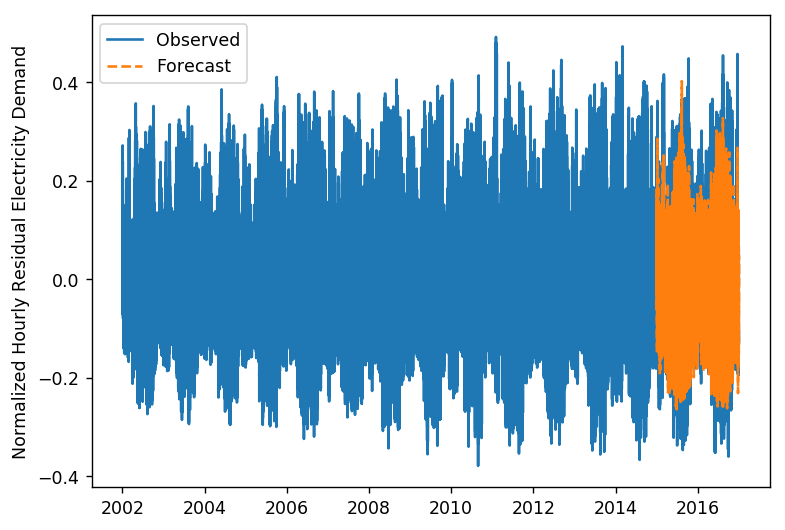

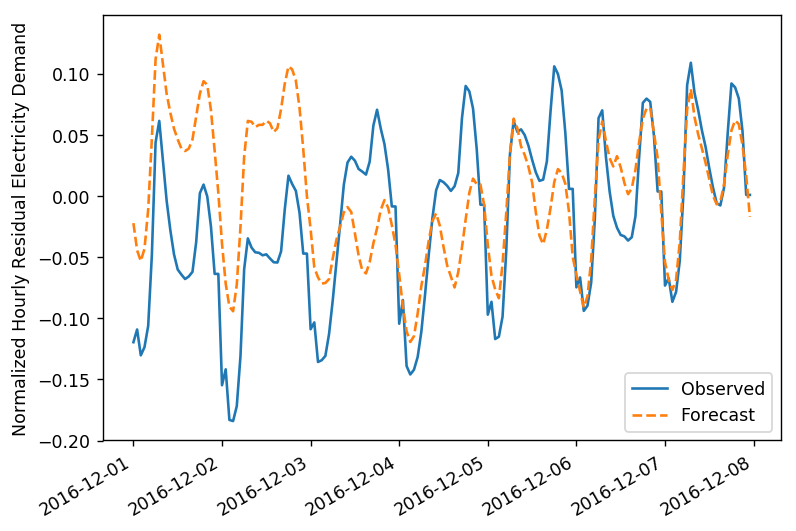

In [58]:
# best hyperparamters
hl, a, lr, mi  = 500, 0.001, 0.0001, 10000

# train model and get predictions
mod_mlp = MLPRegressor(hidden_layer_sizes=hl, alpha=a, learning_rate_init=lr, max_iter=mi)
mod_mlp.fit(X_tr, y_tr)
pred = weekly_forecast(mod_mlp, exog_val, y_init_val)

# compute error, and plot on both long and short time scales
print('MAE:', compute_mae(y_val, pred))
plot_full(yp_full, pred, yp_val.index)
plot_week(yp_full, pred, yp_val.index)

The MLP model also performs better than linear regression, but not as well as GBR. In theory, MLP has the capacity to make extremely accurate predictions, but in practice it can be challenging to properly tune a model. It is expected that a more extensive grid search over a better selection of hyperparameters would yield a more accurate model. 

<a id='evaluate'></a>
## 5. Evaluating Final Models

The predictions from both the monthly and hourly models are combined and evaluated against the test data. The first block of code gets all of the required forecast predictions on the test set for each model. The second block of code adds the hourly and monthly models to get the full electricity demand prediction, and also unnormalizes these predictions back to the scale of the original dataset.

In [59]:
# monthly average forecasts
train_m = monthly_norm[:'2016']
test_m = monthly_norm['2017':]
model_m = SARIMAX(train_m, order=best_monthly_order, seasonal_order=best_monthly_seas_order).fit()
forecast_m = model_m.get_forecast(steps=len(test_m))
pred_m_norm = pd.Series(forecast_m.predicted_mean, index=test_m.index)

# baseline hourly residual forecasts
idx = test.index[::168]
idx = idx.append(pd.DatetimeIndex(['2017-12-31 23']))
pred_base = pd.Series(np.hstack([y_init_te, yp_te.iloc[-1]]), index=idx)
pred_base = pred_base.resample('H').ffill().values

# hourly residual forecasts
pred_lr = weekly_forecast(mod_lr, exog_te, y_init_te)
pred_gbr = weekly_forecast(mod_gbr, exog_te, y_init_te)
pred_mlp = weekly_forecast(mod_mlp, exog_te, y_init_te)

In [60]:
# dataframe of montly forecasts
m_norm_df = pd.DataFrame({'m_norm':pred_m_norm, 'month':pred_m_norm.index.month, 'year':pred_m_norm.index.year})

# baseline: combine monthly/hourly forecasts, unnormalize to original scale
bl_norm_df = pd.DataFrame({'h_norm':pred_base, 'month':test.index.month, 'year':test.index.year})
pred_bl_norm_df = bl_norm_df.merge(m_norm_df, on=['month','year'])
pred_bl_norm = pd.Series((pred_bl_norm_df['m_norm'] + pred_bl_norm_df['h_norm']).values, index=test.index)
pred_bl = pred_bl_norm * (load_max - load_min) + load_min

# linear regression: combine monthly/hourly forecasts, unnormalize to original scale
lr_norm_df = pd.DataFrame({'h_norm':pred_lr, 'month':test.index.month, 'year':test.index.year})
pred_lr_norm_df = lr_norm_df.merge(m_norm_df, on=['month','year'])
pred_lr_norm = pd.Series((pred_lr_norm_df['m_norm'] + pred_lr_norm_df['h_norm']).values, index=test.index)
pred_lr = pred_lr_norm * (load_max - load_min) + load_min

# gradient boosting regression: combine monthly/hourly forecasts, unnormalize to original scale
gbr_norm_df = pd.DataFrame({'h_norm':pred_gbr, 'month':test.index.month, 'year':test.index.year})
pred_gbr_norm_df = gbr_norm_df.merge(m_norm_df, on=['month','year'])
pred_gbr_norm = pd.Series((pred_gbr_norm_df['m_norm'] + pred_gbr_norm_df['h_norm']).values, index=test.index)
pred_gbr = pred_gbr_norm * (load_max - load_min) + load_min

# multi-layer perceptron regression: combine monthly/hourly forecasts, unnormalize to original scale
mlp_norm_df = pd.DataFrame({'h_norm':pred_mlp, 'month':test.index.month, 'year':test.index.year})
pred_mlp_norm_df = mlp_norm_df.merge(m_norm_df, on=['month','year'])
pred_mlp_norm = pd.Series((pred_mlp_norm_df['m_norm'] + pred_mlp_norm_df['h_norm']).values, index=test.index)
pred_mlp = pred_mlp_norm * (load_max - load_min) + load_min

With the full predictions for each model, the performance of each of them can now be evaluated. The MAPE is computed for each model below.

In [61]:
def compute_mape(y, yhat):
    pct_err = ((yhat - y) / y).dropna()
    return np.mean(np.abs(pct_err)) 

print("baseline MAPE:", compute_mape(df['load'], pred_bl))
print("lin reg MAPE:", compute_mape(df['load'], pred_lr))
print("grad boost reg MAPE:", compute_mape(df['load'], pred_gbr))
print("MLP reg MAPE:", compute_mape(df['load'], pred_mlp))

baseline MAPE: 0.18664197323794782
lin reg MAPE: 0.12213760852538987
grad boost reg MAPE: 0.07225700235063952
MLP reg MAPE: 0.08684343952929352


All three models perform better than the baseline. The GBR performs best, followed by MLP, and linear regression is significantly worse than both of these. To visualize the forecasting predictions, below are plots of one-week-out forecasts for each model over a span of two weeks on the test set.

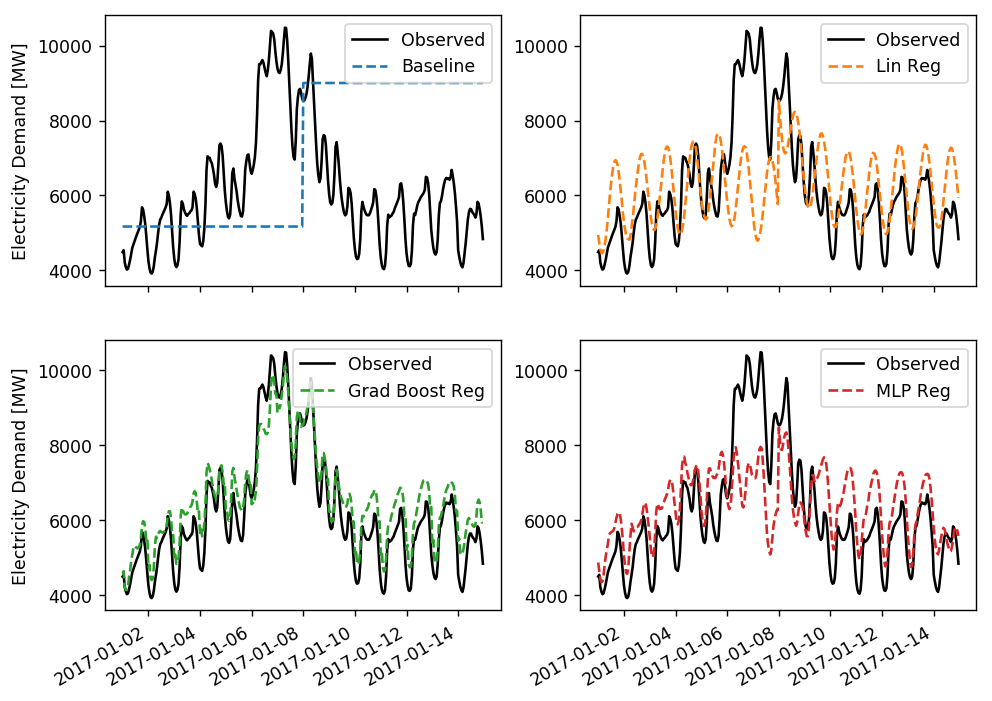

In [62]:
fig, ax = plt.subplots(2,2,figsize=(9,7))

ax[0,0].plot(df.loc['2017-01-01':'2017-01-14','load'], label='Observed', c='k')
ax[0,0].plot(pred_bl['2017-01-01':'2017-01-14'], label='Baseline', ls='--', c='C0')
ax[0,0].set_ylabel('Electricity Demand [MW]')
ax[0,0].legend(loc=1);

ax[0,1].plot(df.loc['2017-01-01':'2017-01-14','load'], label='Observed', c='k')
ax[0,1].plot(pred_lr['2017-01-01':'2017-01-14'], label='Lin Reg', ls='--', c='C1')
ax[0,1].legend(loc=1);

ax[1,0].plot(df.loc['2017-01-01':'2017-01-14','load'], label='Observed', c='k')
ax[1,0].plot(pred_gbr['2017-01-01':'2017-01-14'], label='Grad Boost Reg', ls='--', c='C2')
ax[1,0].set_ylabel('Electricity Demand [MW]')
ax[1,0].legend(loc=1);

ax[1,1].plot(df.loc['2017-01-01':'2017-01-14','load'], label='Observed', c='k')
ax[1,1].plot(pred_mlp['2017-01-01':'2017-01-14'], label='MLP Reg', ls='--', c='C3')
ax[1,1].legend(loc=1);

fig.autofmt_xdate()

In agreement with the MAPE results, GBR clearly has the best performance, followed by MLP. Linear regression performs quite poorly, making almost no attempt to follow the weekly trend as it rises and falls. For completeness, the GBR model predictions are plotted below for the full time span of the test data. 

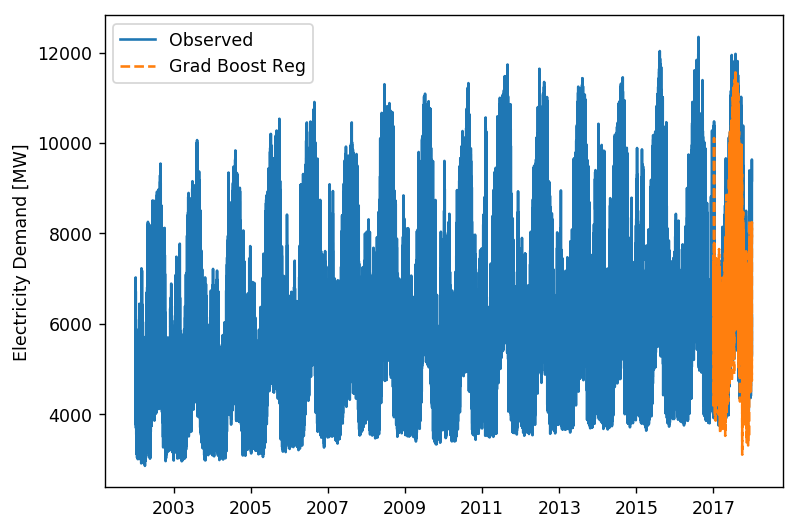

In [63]:
fig = plt.figure()
plt.plot(df.loc[:,'load'], label='Observed')
plt.plot(pred_gbr, label='Grad Boost Reg', ls='--')
plt.ylabel('Electricity Demand [MW]')
plt.legend();

<a id='summary'></a>
## 6. Summary & Future Work

This project considered the issue of forecasting electricity demand at one week intervals with a resolution of one hour. This is an important application for utilities and power plant operators so that they can make informed fuel purchase decisions and schedule maintenece at optimal times. In order to make more accurate forecasts, the original timeseries data was decomposed into monthly averages and hourly residuals. The monthly averages were modeled using a SARIMA model, and the hourly residuals were modeled using three different regression models. Of these, gradient boosting regression showed the best performance on the test set, with a 61% improvement over the baseline persistance model.

The accuracy of the best model (gradient boosting regression) is actually quite good. This model could certainly be used for one-week-out forecasting, at least as a first-order estimate. If a higher accuracy model is required, the authors present two suggestions for further study:

- For both GBR and MLP, only a very rough grid search over hyperparameters was performed, and the possible values of hyperparameters were chosen somewhat arbitrarily. A more thorough investigation of hyperparameters is strongly suggested, especially for MLP.
- The most obvious features for predicting electricity demand were used in this project: autoregressive features, temporal features, and weather features. A study of where the model is predicting with the lowest accuracies could be interesting, with the hope of finding a pattern which could be fixed with additional features. For example, if one found that the model was consistently under-predicting electricity demand during major sporting events, adding a boolean feature of "major_event" could help improve model accuracy. 